<a href="https://colab.research.google.com/github/bcaffo/ds4bme_intro/blob/master/notebooks/notebook5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear separable models

We've now covered two ways to do prediction with a single variable, classification using logistic regression and prediction using a line and least squares. What if we have several predictiors? 

In both the logistic and linear regression models, we had a linear predictor, specifically, 
$$
\eta_i = \beta_0 + \beta_1 x_i.
$$
In the continuous case, we were modeling the expected value of the outcomes as linear. In the binary case, we were assuming that the naturual logarithm of the odds of a 1 outcome was linear. 

To estimate the unknown parameters, $\beta_0$ and $\beta_1$ we minimized
$$
\sum_{i=1}^n || y_i - \eta_i||^2 
$$
in the linear case and 
$$
-\sum_{i=1}^n \left[
  Y_i \eta_i + \log\left\{\frac{1}{1 + e^{\eta_i}} \right\} \right].
$$
in the binary outcome case (where, recall, $\eta_i$ depends on the parameters). 

We can easily extend these models to multiple predictors by assuming that the impact of the multiple predictors is linear and separable. That is,

$$
\eta_i = \beta_0 + \beta_1 x_{1i} + \beta_2 x_{2i} + \ldots \beta_{p-1} x_{p-1,i}
$$

If we think about this as vectors and matrices, we obtain

$$
\eta = X \beta
$$
where $\eta$ is an $n \times 1$ vector, $X$ is an $n \times p$ matrix with $i,j$ entry $x_{ij}$ and $\beta$ is a $p\times 1$ vector with entries $\beta_j$. 


Let's look at the voxel-level data that we've been working with. First let's load the data.

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as lm
import sklearn as skl
import statsmodels.formula.api as smf
import statsmodels as sm

## this sets some style parameters
sns.set()

## Download in the data if it's not already there
! if [ ! -e oasis.csv ]; \
then wget https://raw.githubusercontent.com/bcaffo/ds4bme_intro/master/data/oasis.csv; \
fi;

## Read in the data and display a few rows
dat = pd.read_csv("oasis.csv")

Let's first try to fit the proton density data from the other imaging data. I'm going to use the `statsmodels` version of linear models since it has a nice format for dataframes.

In [0]:
trainFraction = .75

sample = np.random.uniform(size = 100) < trainFraction
trainingDat = dat[sample]
testingDat = dat[~sample]

In [26]:
results = smf.ols('PD ~ FLAIR + T1 + T2  + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', data = trainingDat).fit()
print(results.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.773   
Dependent Variable: PD               AIC:                72.6331 
Date:               2019-09-23 19:22 BIC:                91.2790 
No. Observations:   76               Log-Likelihood:     -28.317 
Df Model:           7                F-statistic:        37.44   
Df Residuals:       68               Prob (F-statistic): 6.19e-21
R-squared:          0.794            Scale:              0.13787 
------------------------------------------------------------------
               Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
------------------------------------------------------------------
Intercept      0.1781    0.1441   1.2366  0.2205  -0.1093   0.4656
FLAIR         -0.0103    0.0909  -0.1131  0.9103  -0.1917   0.1711
T1            -0.2067    0.0873  -2.3664  0.0208  -0.3810  -0.0324
T2             0.6145    0.0825   7.4528  0.0000   0.4500   0.7790
FLAIR_10      -0.288

In [27]:
x = dat[['FLAIR','T1', 'T2', 'FLAIR_10', 'T1_10', 'T2_10', 'FLAIR_20']]
y = dat[['GOLD_Lesions']]
## Add the intercept column
x = sm.tools.add_constant(x)

xtraining = x[sample]
xtesting = x[~sample]
ytraining = y[sample]
ytesting = y[~sample]


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [28]:
fit = sm.discrete.discrete_model.Logit(ytraining, xtraining).fit()

Optimization terminated successfully.
         Current function value: 0.253784
         Iterations 8


In [13]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                   71
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            7
Date:                Mon, 23 Sep 2019   Pseudo R-squ.:                  0.6515
Time:                        18:22:05   Log-Likelihood:                -17.150
converged:                       True   LL-Null:                       -49.206
Covariance Type:            nonrobust   LLR p-value:                 2.266e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.7783      1.985     -2.407      0.016      -8.668      -0.888
FLAIR          2.6983      1.353      1.994      0.046       0.046       5.351
T1             3.0484      1.306      2.334      0.020       0.489       5.608
T2             2.1443      1.196      1.793      0.073      -0.199       4.488
FLAIR_10       4.9421      4.256      1.161      0.246      -3.400      13.284
T1_10         -0.3192      2.331     -0.137      0.891      -4.888       4.250
T2_10         -4.9192      4.014     -1.226      0.220     -12.786       2.947
FLAIR_20     -16.6939      9.496     -1.758      0.079     -35.306       1.918
==============================================================================
"""

Now let's evaluate our prediction. Here, we're not going to classify as 0 or 1, but rather estimate the prediction. Note, we then would need to pick a threshold to have a classifier. We could use .5 as our threshold. However, it's often the case that we don't necessarily want to threshold at specifically that level. A solution for evalution is to plot how the sensitivity and specificity change by the threshold. 

In other words, consider the triplets
$$
(t, sens(t), spec(t))
$$
where $t$ is the threshold, `sens(t)` is the sensitivity at threshold $t$, `spec(t)` is the specificity at threshold `t`. 

Necessarily, the sensitivity and specificity 



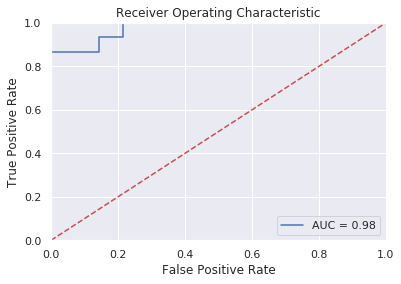

In [22]:
phatTesting = fit.predict(xtesting)

## See here for plotting
## https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python
fpr, tpr, threshold = skl.metrics.roc_curve(ytesting, phatTesting)
roc_auc = skl.metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


## Aside different python packages

So far we've explored several plotting libraries including: default pandas methods, matplotlib, seaborn and plotly. We've also looked at several fitting libraries including to some extent numpy, but especially scikitlearn and statsmodels. What's the difference? Well, these packages are all mantained by different people and have different features and goals. For example, scikitlearn is more expansive than statsmodels, but statsmodels functions more like one is used to with statistical output. Matplotlib is very expansive, but seaborn has nicer default options and is a little easier. So, when doing data science with python, one has to get used to trying out a few packages, weighing the cost and benefits of each, and picking one. 

'statsmodels', what we're using above, has multiple methods for fitting binary models including: `sm.Logit`, `smf.logit`, `BinaryModel` and `glm`. Here I'm just going to use `Logit` which does not use the formula syntax of `logit`. Note, by default, this does not add an intercept this way. So, I'm adding a column of ones, which adds an intercept.

Consider the following which uses the formula API


In [17]:
results = smf.logit(formula = 'GOLD_Lesions ~ FLAIR + T1 + T2 + FLAIR_10 + T1_10 + T2_10 + FLAIR_20', data = trainingDat).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.241546
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           GOLD_Lesions   No. Observations:                   71
Model:                          Logit   Df Residuals:                       63
Method:                           MLE   Df Model:                            7
Date:                Mon, 23 Sep 2019   Pseudo R-squ.:                  0.6515
Time:                        18:23:47   Log-Likelihood:                -17.150
converged:                       True   LL-Null:                       -49.206
Covariance Type:            nonrobust   LLR p-value:                 2.266e-11
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.7783      1.985     -2.407      0.016      -8.668      -0.888
FLAIR          2.6983      1.353      1.994      0.046       0.046       5.351
T1             3.0484      1.306      2.334      0.020       0.489       5.608
T2             2.1443      1.196      1.793      0.073      -0.199       4.488
FLAIR_10       4.9421      4.256      1.161      0.246      -3.400      13.284
T1_10         -0.3192      2.331     -0.137      0.891      -4.888       4.250
T2_10         -4.9192      4.014     -1.226      0.220     -12.786       2.947
FLAIR_20     -16.6939      9.496     -1.758      0.079     -35.306       1.918
==============================================================================
"""